<a id="toc"></a>
# **Rainfall Prediction: XGBoost**

Table of Contents:
- [About the Project](#1)
- [About the Data](#2)
- [Set Up](#3)
- [Exploratory Data Analysis](#4)
    - [Training Data Overview](#4.1)
    - [Testing Data Overview](#4.2)
    - [Target Variable: Rainfall](#4.3)
    - [Numerical Features](#4.4)
    - [Feature Interactions](#4.5)
- [Adversarial Validation: Include Original Data?](#5)
- [Data Preprocessing](#6)
    - [Combining the Data](#6.1)
    - [Missing Values](#6.2)
    - [Removing Outliers](#6.3)
    - [Feature Engineering](#6.4)
    - [Feature Scaling](#6.5)
- [Building the Model](#7)
    - [Baseline Model](#7.1)
    - [Optimizing with Optuna](#7.2)
- [Model Evaluation](#8)
- [Conclusion](#9)
- [Submission](#10)
- [References](#r)


<a id="toc"></a>

<a href="#2" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="1"></a>
# **1) About the Project**

---


This project has been completed as part of [Kaggle's Playground Series competitions](https://www.kaggle.com/competitions/playground-series-s5e3/overview) (Season 5, Episode 3). The overarching goal of this project is to develop a model to predict whether or not there will be rainfall for each day of the year. 

In this project, I will first briefly explore the datasets by viewing basic summary statistics and visualizing the distributions of the target variable and the numerical features. I will also explore potential correlation/interaction amongst features via the use of heatmaps, pair plots, and violin plots.

Following the brief EDA, I will employ adversarial validation to determine whether or not the original data (discussed in the 'About the Data' section) follows the same distribution as Kaggle's synthetic data. This step will likely be a key factor in the final model's performance, as incorporating data from a different distribution can sometimes negatively impact a model's performance on the withheld testing data.

In order to prepare the data for modeling, I will impute missing values with column means, remove outliers using the Inter Quartile method, and scale the data using a MinMax scaler.

The final model will be an [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) model. XGBoost (XGB) is an optimized distributed gradient boosting algorithm that leverages parallel tree boosting to solve a majority of data science tasks. In the case of this project, the overall task is binary classification.

In order to identify the best model, I will use [optuna](https://optuna.org/), which is a hyperparameter optimization framework. Optuna will create and run through 100 trials to determine the ideal hyperparameters for the final LGBM model.

The final model of this project will be evaluated using the area under the curve (AUC) of the receiver operating characteristic curve (ROC curve). The [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is esentially the plot of the true positive rate versus the false positive rate. In the case of this model and competition, a 'perfect' model would yield an AUC of 1.0, while a terrible model would likely result in an AUC of 0.5 (basically random guess). However, obtaining an AUC of 1 is typically impossible, so the objective will be to get the AUC as close to 1.0 as possible.

<a id="toc"></a>

<a href="#toc" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#3" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="2"></a>
# **2) About the Data**

---


The datasets (both train and test) provided in this competition were generated from a deep learning model trained on the original [Rainfall Prediction using Machine Learning](https://www.kaggle.com/datasets/subho117/rainfall-prediction-using-machine-learning) dataset. Kaggle explicitly states that the feature distributions of the synthetic datasets are 'close to, but not exactly the same' as the original. Because of this, I will be using adversarial validation to determine how similar (or different) the distributions of these datasets are.

Target Variable:
- Rainfall --> (0 = No, 1 = Yes)

Feature Variables:
- ID
- Day
- Pressure
- Maxtemp
- Temparature
- Mintemp
- Dewpoint
- Humidity
- Cloud
- Sunshine
- Winddirection
- Windspeed

The Kaggle datasets are publicly available under the MIT license. The original dataset is publicly available under the Apache 2.0 license. 

<a id="toc"></a>

<a href="#toc" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#4" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="3"></a>
# **3) Set Up**

---

In [1]:
# Importing and loading necessary libraries and packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style = 'white', palette = 'Set2')
pal = sns.color_palette('Set2')

import catboost
from catboost import Pool, CatBoostClassifier
from catboost.utils import eval_metric

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
xgb.set_config(verbosity=0)

import optuna
from optuna.samplers import TPESampler

import shap
shap.initjs()

import lightgbm
from lightgbm import plot_importance

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading in the datasets
df_train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
df_original = pd.read_csv("/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv")

<a id="toc"></a>

<a href="#toc" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#5" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="4"></a>
# **4) Exploratory Data Analysis**

---

<a id="toc"></a>
<a id="4.1"></a>
## **4.1) Training Data Overview**

In [3]:
# Viewing first 5 entries of 'df_train'
df_train.head()

id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  
0   88.0       1.1           60.0       17.2         1  
1   91.0       0.0           50.0       21.9         1  
2   47.0       8.3           70.0       18.1         1  
3   95.0       0.0           60.0       35.6         1  
4   45.0       3.6           40.0       24.8         0

In [4]:
# Looking at the info of 'df_train'
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB


In [5]:
# Creating a function to show a summary of a given dataset
def show_sum(df):
    sum_df = pd.DataFrame(index = list(df))
    sum_df['Dtype'] = df.dtypes
    sum_df['Count'] = df.count()
    sum_df['#Unique'] = df.nunique()
    sum_df['%Unique'] = sum_df['#Unique'] / len(df) * 100
    sum_df['#Null'] = df.isnull().sum()
    sum_df['%Null'] = sum_df['#Null'] / len(df) * 100
    print(sum_df)

In [6]:
# Examining summary of 'df_train'
show_sum(df_train)

                 Dtype  Count  #Unique     %Unique  #Null  %Null
id               int64   2190     2190  100.000000      0    0.0
day              int64   2190      365   16.666667      0    0.0
pressure       float64   2190      236   10.776256      0    0.0
maxtemp        float64   2190      219   10.000000      0    0.0
temparature    float64   2190      198    9.041096      0    0.0
mintemp        float64   2190      199    9.086758      0    0.0
dewpoint       float64   2190      218    9.954338      0    0.0
humidity       float64   2190       49    2.237443      0    0.0
cloud          float64   2190       78    3.561644      0    0.0
sunshine       float64   2190      120    5.479452      0    0.0
winddirection  float64   2190       35    1.598174      0    0.0
windspeed      float64   2190      223   10.182648      0    0.0
rainfall         int64   2190        2    0.091324      0    0.0


In [7]:
# Examining summary statistics of each column in 'df_train'
df_train.describe()

id          day     pressure      maxtemp  temparature  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean   1094.500000   179.948402  1013.602146    26.365799    23.953059   
std     632.342866   105.203592     5.655366     5.654330     5.222410   
min       0.000000     1.000000   999.000000    10.400000     7.400000   
25%     547.250000    89.000000  1008.600000    21.300000    19.300000   
50%    1094.500000   178.500000  1013.000000    27.800000    25.500000   
75%    1641.750000   270.000000  1017.775000    31.200000    28.400000   
max    2189.000000   365.000000  1034.600000    36.000000    31.500000   

           mintemp     dewpoint     humidity        cloud     sunshine  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean     22.170091    20.454566    82.036530    75.721918     3.744429   
std       5.059120     5.288406     7.800654    18.026498     3.626327   
min       4.000000    -0.300000    39.000000     2.000000     0.000000   
25%      17.700000    16.800000    77.000000    69.000000     0.400000   
50%      23.850000    22.150000    82.000000    83.000000     2.400000   
75%      26.400000    25.000000    88.000000    88.000000     6.800000   
max      29.800000    26.700000    98.000000   100.000000    12.100000   

       winddirection    windspeed     rainfall  
count    2190.000000  2190.000000  2190.000000  
mean      104.863151    21.804703     0.753425  
std        80.002416     9.898659     0.431116  
min        10.000000     4.400000     0.000000  
25%        40.000000    14.125000     1.000000  
50%        70.000000    20.500000     1.000000  
75%       200.000000    27.900000     1.000000  
max       300.000000    59.500000     1.000000

**OBSERVATIONS: 'df_train'**
- Shape of the data:
    - 2190 (rows), 13 (columns)
- Includes target variable 'rainfall'
- All columns have a numerical datatype:
    - Float64 (10 columns)
    - Int64 (3 columns)
- 0 missing values


**Summary Statistics: 'df_train'**

- **Pressure**:
    - Mean: **1013.60**; Max: **1034.60**; Min: **999.00**
    - Unit: Hectopascal (hPa)
- **Maxtemp**:
    - Mean: **26.37**; Max: **36.00**; Min: **10.40**
    - Unit: Degrees Celcius (°C)
- **Temparature**:
    - Mean: **23.95**; Max: **31.50**; Min: **7.40**
    - Unit: Degrees Celcius (°C)
- **Mintemp**:
    - Mean: **22.17**; Max: **29.80**; Min: **4.00**
    - Unit: Degrees Celcius (°C)
- **Dewpoint**:
    - Mean: **20.45**; Max: **26.70**; Min: **-0.30**
    - Unit: Degrees Celcius (°C)
- **Humidity**:
    - Mean: **82.04**; Max: **98.00**; Min: **39.00**
    - Unit: %
- **Cloud**:
    - Mean: **75.72**; Max: **100.00**; Min: **2.00**
    - Unit: % 
- **Sunshine**:
    - Mean: **3.74**; Max: **12.10**; Min: **0.00**
    - Unit: Hours
- **Winddirection**:
    - Mean: **104.86**; Max: **300.00**; Min: **10.00**
    - Unit: Degrees (0-360)
- **Windspeed**:
    - Mean: **21.80**; Max: **59.50**; Min: **4.40**
    - Unit: Kilometers per Hour (km/h)
- **Rainfall (TARGET)**:
    - Mean: **0.75**; Max: **1**; Min: **0**
    - Unit: Binary Variable (1 --> Rain, 0 --> No Rain)

<a id="toc"></a>
<a id="4.2"></a>
## **4.2) Testing Data Overview**

In [8]:
# Viewing first 5 entries of 'df_test'
df_test.head()

id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0  2190    1    1019.5     17.5         15.8     12.7      14.9      96.0   
1  2191    2    1016.5     17.5         16.5     15.8      15.1      97.0   
2  2192    3    1023.9     11.2         10.4      9.4       8.9      86.0   
3  2193    4    1022.9     20.6         17.3     15.2       9.5      75.0   
4  2194    5    1022.2     16.1         13.8      6.4       4.3      68.0   

   cloud  sunshine  winddirection  windspeed  
0   99.0       0.0           50.0       24.3  
1   99.0       0.0           50.0       35.3  
2   96.0       0.0           40.0       16.9  
3   45.0       7.1           20.0       50.6  
4   49.0       9.2           20.0       19.4

In [9]:
# Looking at the info of 'df_test'
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  729 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB


In [10]:
# Examining summary of 'df_test'
show_sum(df_test)

                 Dtype  Count  #Unique     %Unique  #Null     %Null
id               int64    730      730  100.000000      0  0.000000
day              int64    730      365   50.000000      0  0.000000
pressure       float64    730      185   25.342466      0  0.000000
maxtemp        float64    730      182   24.931507      0  0.000000
temparature    float64    730      175   23.972603      0  0.000000
mintemp        float64    730      171   23.424658      0  0.000000
dewpoint       float64    730      172   23.561644      0  0.000000
humidity       float64    730       42    5.753425      0  0.000000
cloud          float64    730       69    9.452055      0  0.000000
sunshine       float64    730      110   15.068493      0  0.000000
winddirection  float64    729       29    3.972603      1  0.136986
windspeed      float64    730      205   28.082192      0  0.000000


In [11]:
# Examining summary statistics of each column in 'df_test'
df_test.describe()

id         day     pressure     maxtemp  temparature  \
count   730.000000  730.000000   730.000000  730.000000   730.000000   
mean   2554.500000  183.000000  1013.503014   26.372466    23.963288   
std     210.877136  105.438271     5.505871    5.672521     5.278098   
min    2190.000000    1.000000  1000.000000    7.400000     5.900000   
25%    2372.250000   92.000000  1008.725000   21.600000    19.825000   
50%    2554.500000  183.000000  1012.700000   27.800000    25.650000   
75%    2736.750000  274.000000  1017.600000   31.000000    28.375000   
max    2919.000000  365.000000  1032.200000   35.800000    31.800000   

          mintemp    dewpoint    humidity       cloud    sunshine  \
count  730.000000  730.000000  730.000000  730.000000  730.000000   
mean    22.110274   20.460137   82.669863   76.360274    3.664384   
std      5.170744    5.391169    7.818714   17.934121    3.639272   
min      4.200000   -0.000000   39.000000    0.000000    0.000000   
25%     17.825000   16.800000   77.250000   69.000000    0.325000   
50%     23.900000   22.300000   82.000000   83.000000    2.200000   
75%     26.400000   25.000000   89.000000   88.000000    6.675000   
max     29.100000   26.700000   98.000000  100.000000   11.800000   

       winddirection   windspeed  
count     729.000000  730.000000  
mean      103.923182   22.484247  
std        81.695458    9.954779  
min        10.000000    4.500000  
25%        40.000000   14.500000  
50%        70.000000   21.300000  
75%       200.000000   28.400000  
max       300.000000   59.500000

**OBSERVATIONS: 'df_test'**
- Shape of the data:
    - 730 (rows), 12 (columns)
- Does NOT include target variable 'rainfall'
- All columns have a numerical datatype:
    - Float64 (10 columns)
    - Int64 (2 columns)
- 1 missing value in 'winddirection' column

<a id="toc"></a>
<a id="4.3"></a>
## **4.3) Target Variable: Rainfall**

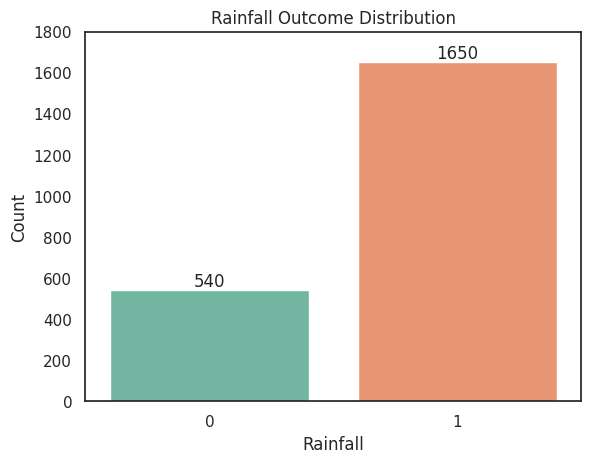

In [12]:
# Creating countplot for target variable 'rainfall'
ax = sns.countplot(x='rainfall', data=df_train, palette='Set2')
for label in ax.containers:
  ax.bar_label(label)
ax.set_ylabel('Count')
ax.set_xlabel('Rainfall')
ax.set_title('Rainfall Outcome Distribution')
ax.set_ylim(0, 1800)
plt.show()

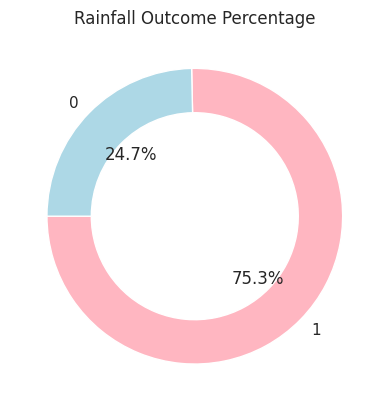

In [13]:
# Creating donut chart for target variable 'rainfall'
plt.plot(1, 2, 1)
df_train['rainfall'].value_counts().plot.pie(
        autopct='%1.1f%%', colors=['lightpink', 'lightblue'], wedgeprops=dict(width=0.3), startangle=180)
plt.ylabel(None)
plt.title('Rainfall Outcome Percentage')
plt.show()

OBSERVATIONS: Target Variable 'rainfall'
- The two classes (0,1) are imbalanced
- The majority (75.3%) of outcomes are 1, i.e. there was rainfall

From the two charts above, we can clearly see that the two classes in the target variable 'rainfall' are imbalanced. In other words, one class (in this case, 1) has a significantly higher number of observations. This could pose an issue, as some machine learning models trained on imbalanced data may exhibit bias by favoring the majority class. Such imbalances can be remedied via different sampling techniques.

<a id="toc"></a>
<a id="4.4"></a>
## **4.4) Numerical Features**

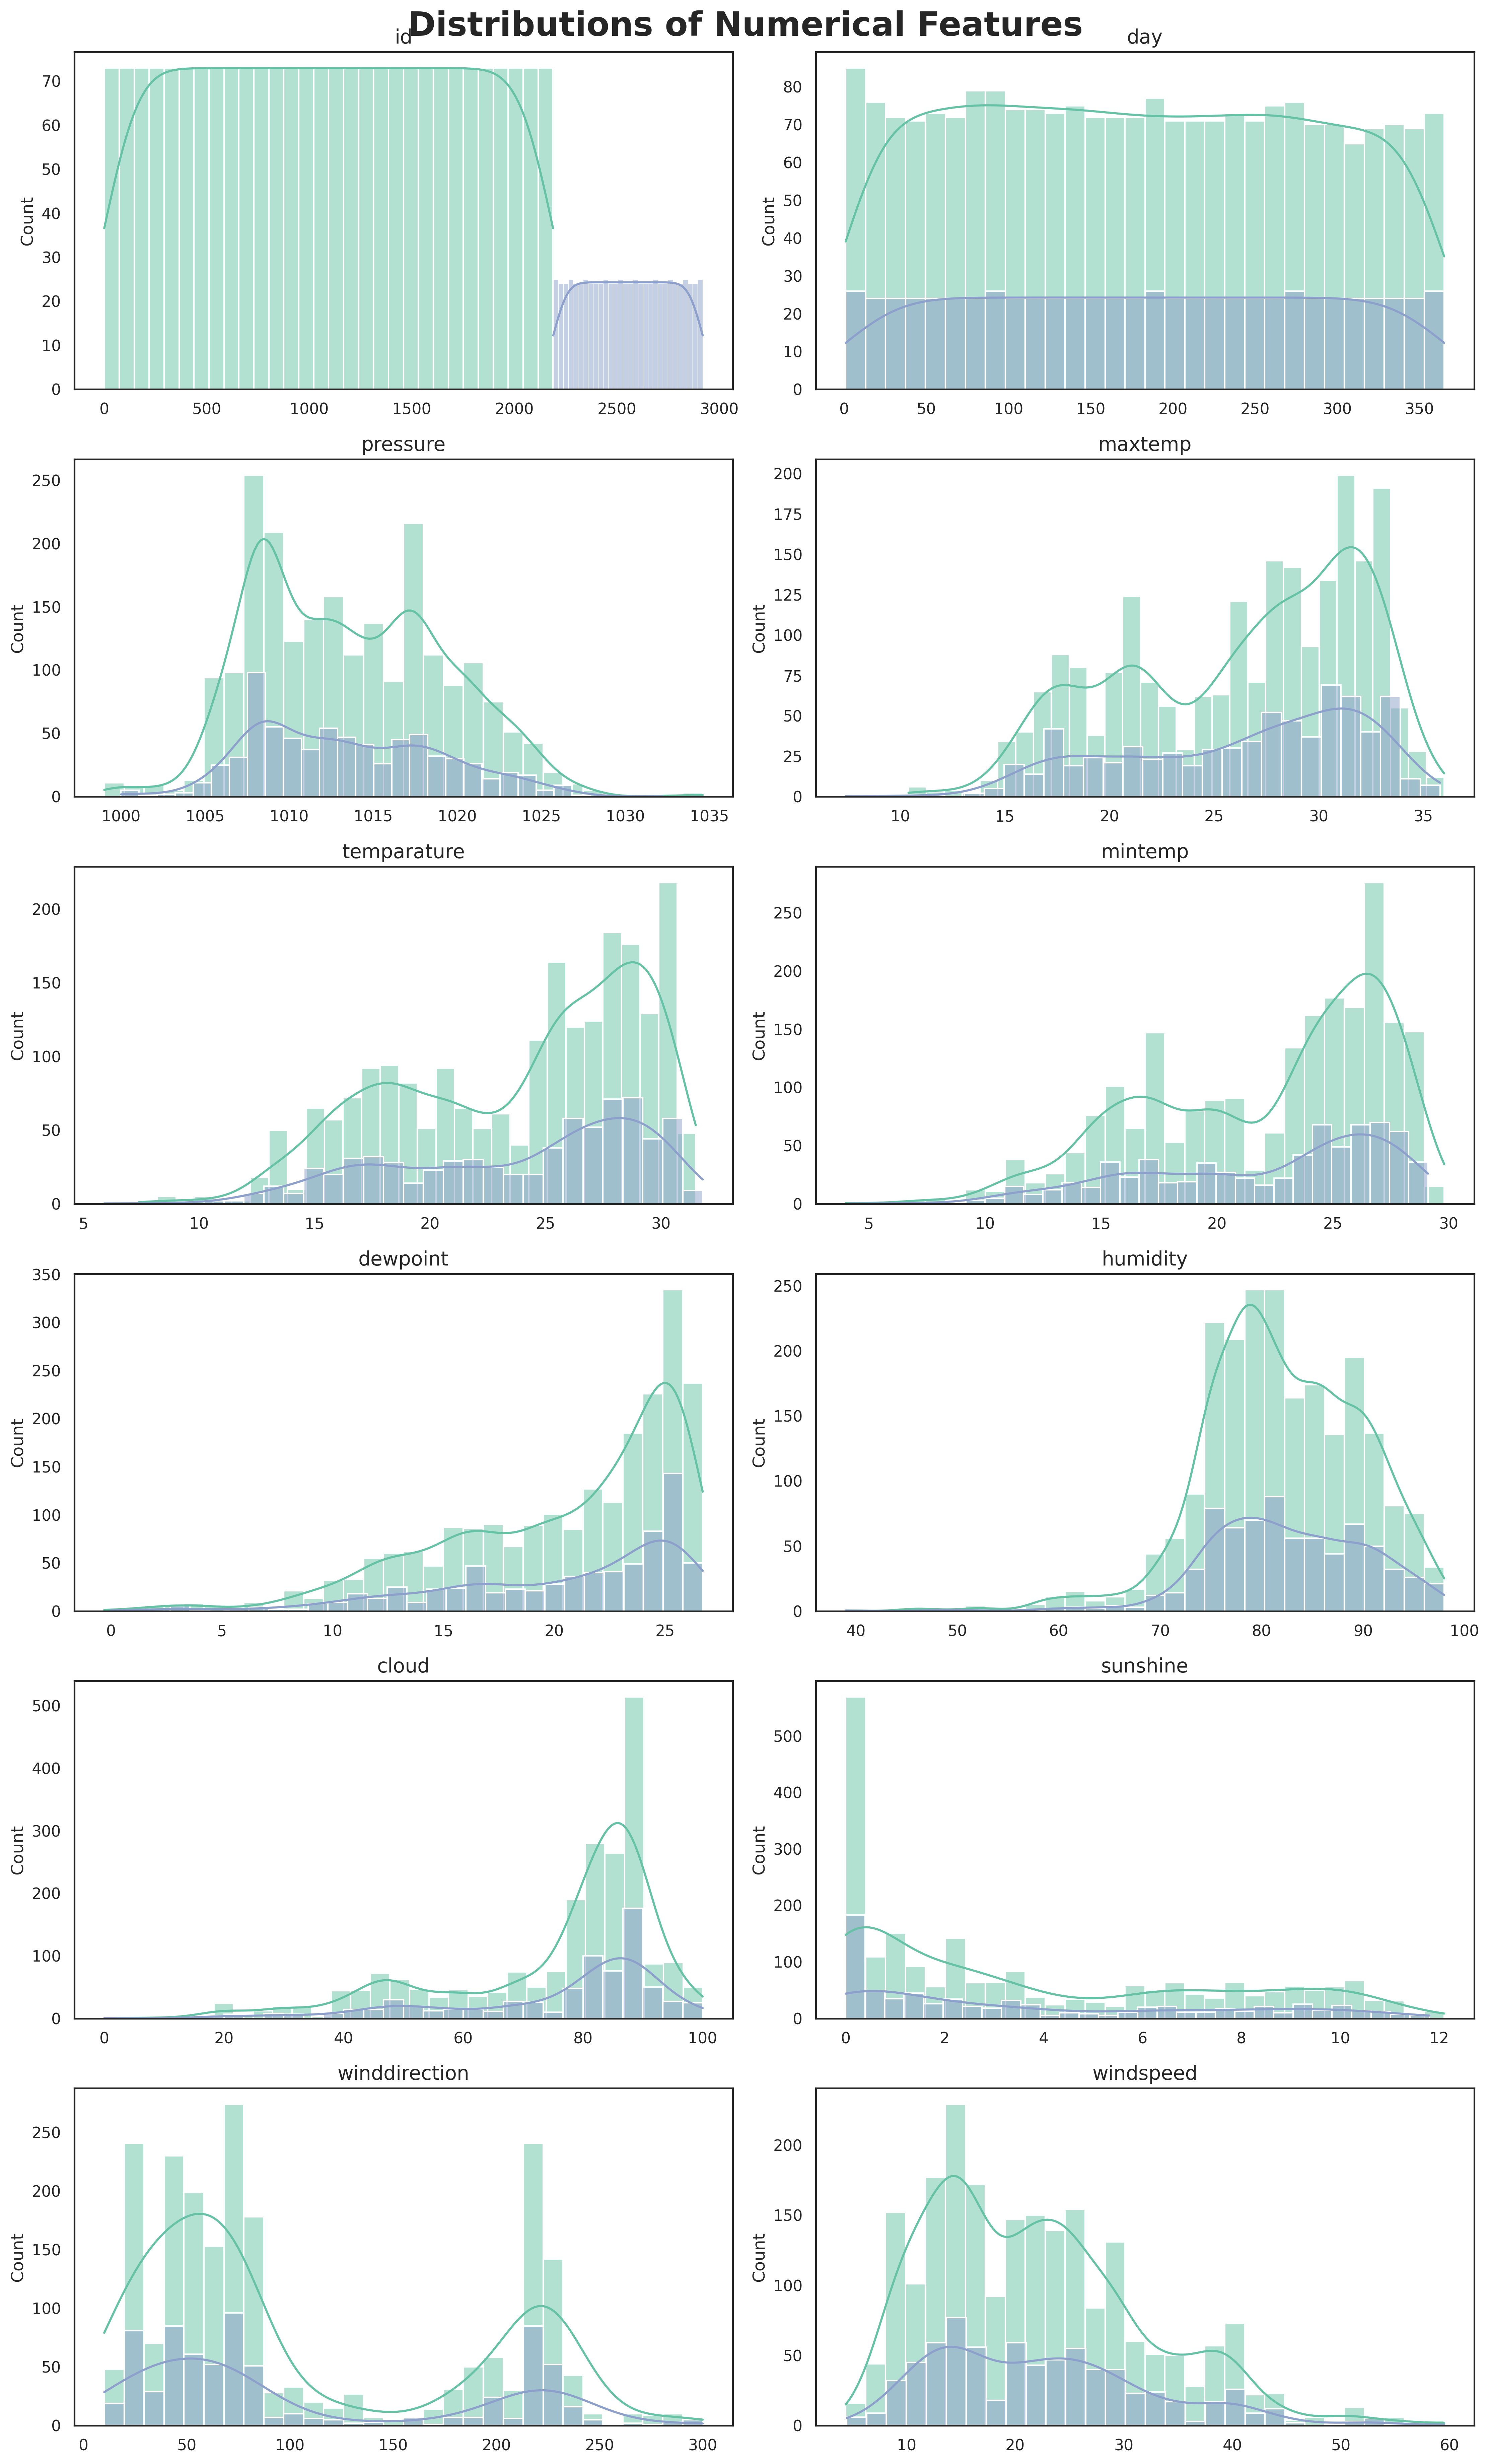

In [14]:
# Visualizing distributions of numerical features (histograms with KDE line)
fig, ax = plt.subplots(6, 2, figsize = (15, 25), dpi = 300)
ax = ax.flatten()
data_numerical = df_train.drop(['rainfall'], axis=1)
features = data_numerical.columns

for i, column in enumerate(features):

    sns.histplot(df_train[column], ax=ax[i], color=pal[0], fill=True, kde=True, bins=30)
    sns.histplot(df_test[column], ax=ax[i], color=pal[2], fill=True, kde=True, bins=30)
    ax[i].set_title(f'{column}', size = 14)
    ax[i].set_xlabel(None)

fig.suptitle('Distributions of Numerical Features', fontsize = 24, fontweight = 'bold')
plt.tight_layout()

The histograms above show the distributions of each of the numerical features. Each chart includes the distributions from both the train and test datasets. Here, we can verify that the train and test sets follow roughly the same distribution. 

<a id="toc"></a>
<a id="4.5"></a>
## **4.5) Feature Interactions**

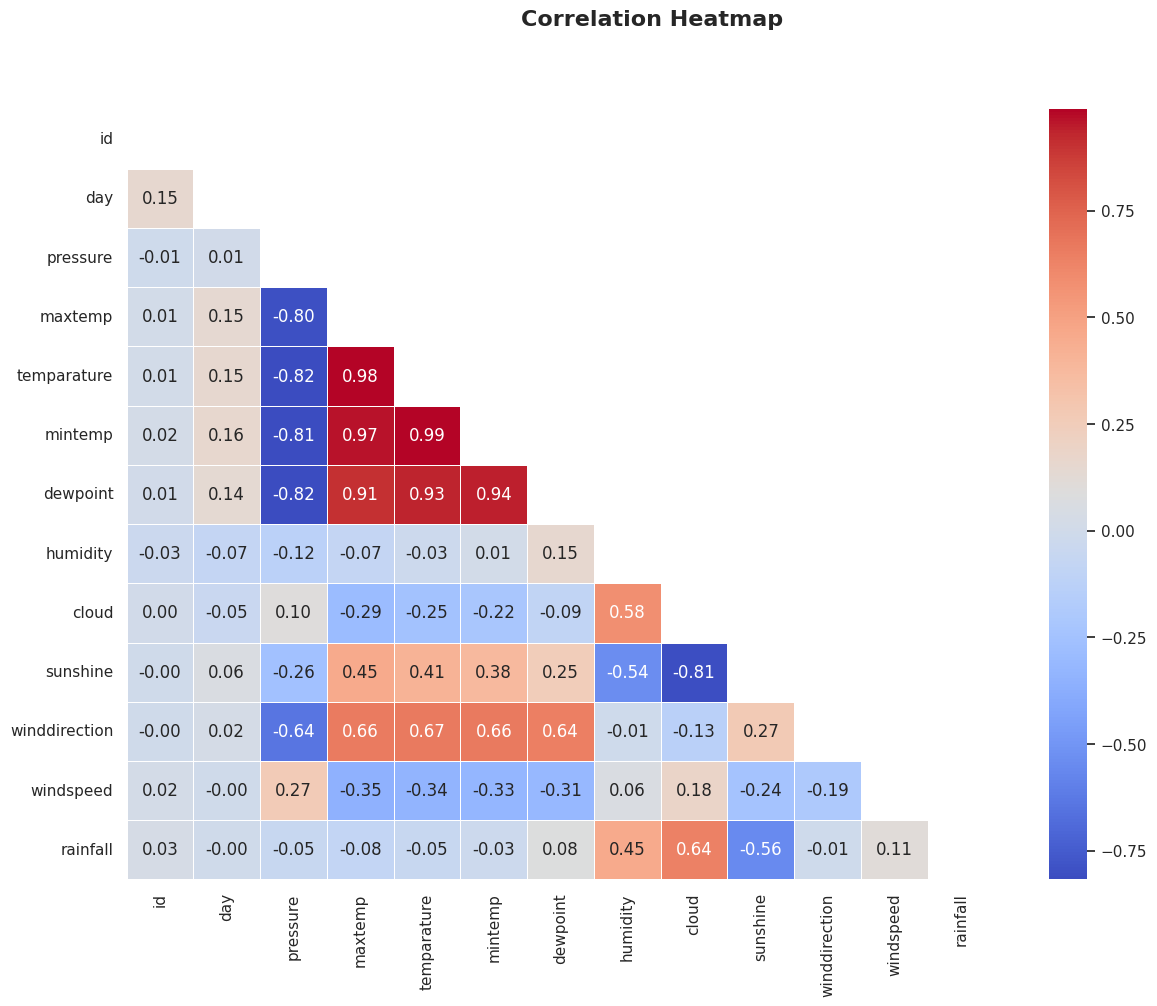

In [15]:
# Visualizing correlation heatmap 
plt.figure(figsize=(14,10))
corr=df_train.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm',mask=np.triu(corr), linewidths=0.5, fmt=',.2f')
plt.suptitle('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()

The chart above is a correlation heatmap of all features and the target variable. Each variable is compared to all others, thus eliciting a correlation value. Values approaching 1 suggest a positive correlation, i.e. as the value of one feature increases, so does the value of the other. In contrast, values approaching -1 suggest a negative correlation, where an increase in the value of one feature causes a decrease in the value of the other. Values close to 0 suggest that there may be little interaction between features.

Some of the correlations seen above, such as the 0.99 correlation between 'mintemp' and 'temparature' are obvious, as the values of 'mintemp' are effectively tied to the 'temparature' measurement, i.e. as the temperature increases, so would the mimimum temperature. Futhermore, the strong negative correlation of -0.81 between 'sunshine' and 'cloud' is also self-evident, as the hours of sunshine would typically decrease as the cloud cover percentage increases.

The target variable 'rainfall' has two interesting, yet not very significant, correlations with 'cloud' (0.64) and 'sunshine' (-0.56). This seems realistic, as one would wager that an increase in cloud coverage may suggest the threat of rain. In contrast to this, an increase in sun would likely suggest that it is not going to rain.

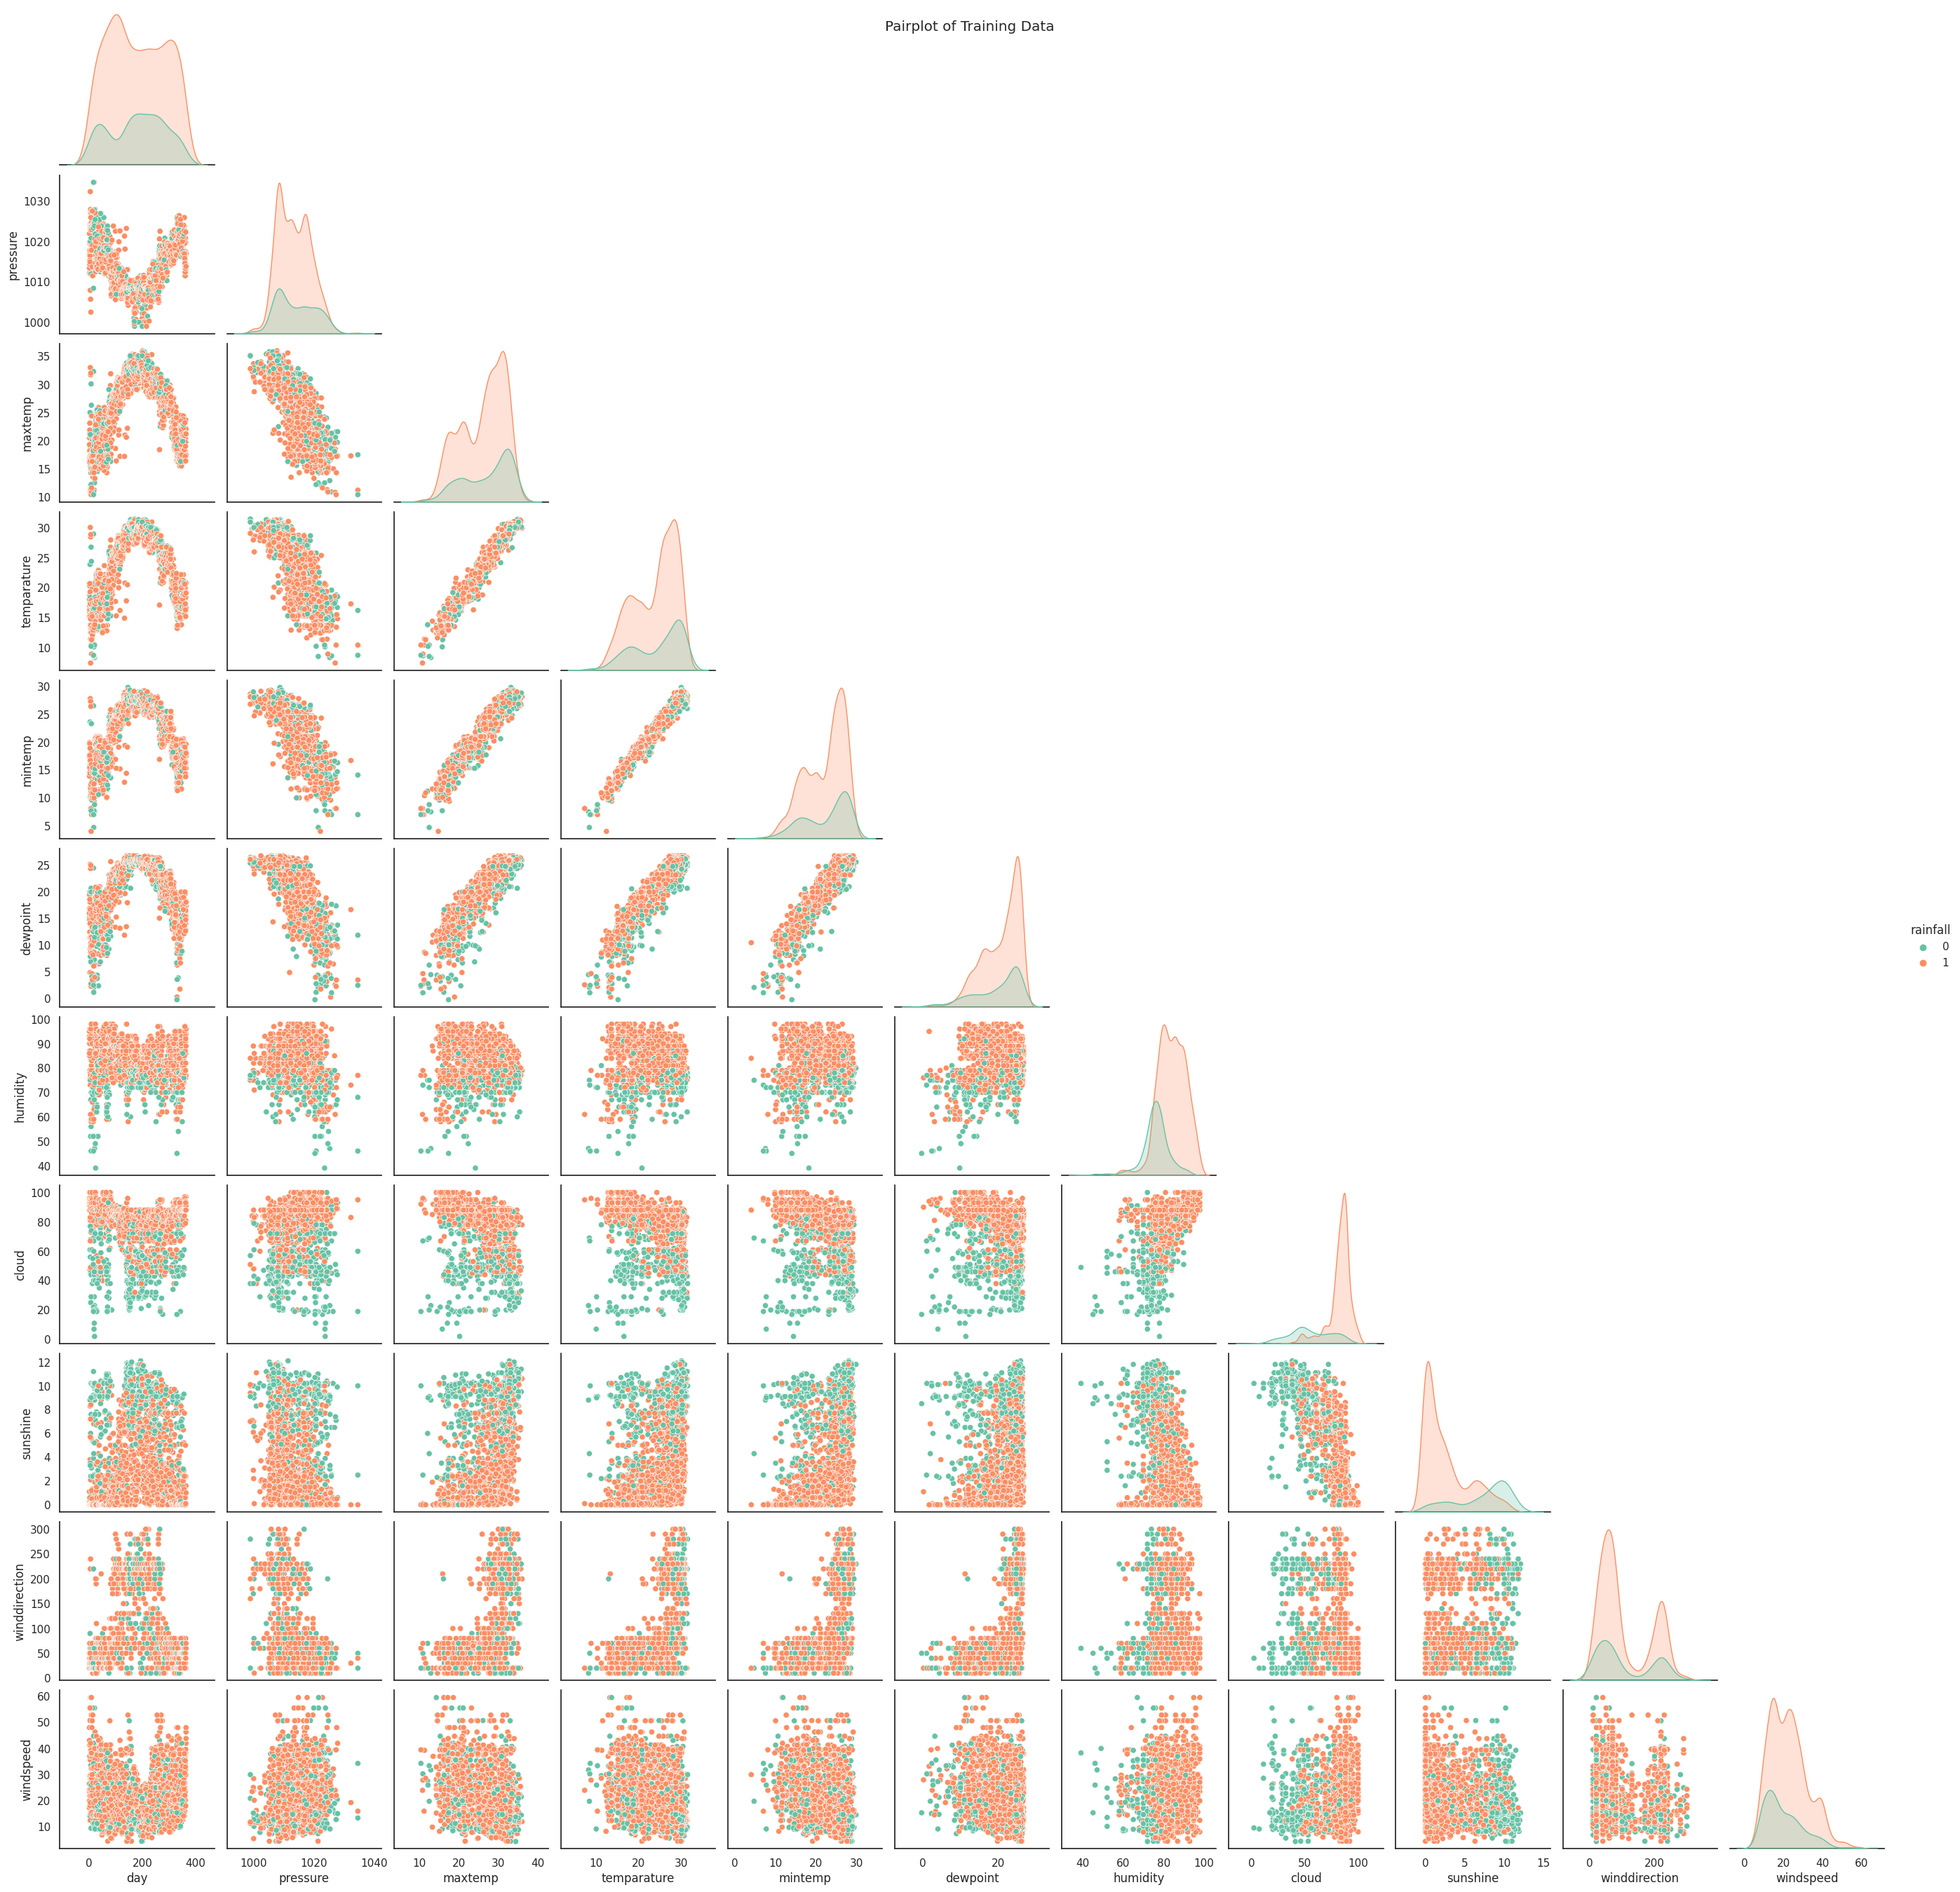

In [16]:
# Visualizing pairplot of 'df_train'
sns.pairplot(df_train.drop('id', axis=1), hue='rainfall', corner=True)
plt.suptitle('Pairplot of Training Data')
plt.show()

The chart above is a pair plot. Pair plots provide further insight into the relationships between variables via the usage of scatterplots and kernel density estimate (KDE) plots. Due to the large number of plots in this image, it can be difficult to extract meaningful insight. However, at a glance, we can see that each individual plot has different colored points for each class. These points often form clusters, which can be used to infer possible interactions. 

For example, we can observe the pair plot of 'cloud' and 'temparature'. Here, we can see that the blue points (class 0, no rain) tend to appear at lower y-values and the orange points (class 1, rain) tend to appear at higher y-values. This suggests that most of the rain occurs when there is a higher percentage of cloud coverage. In terms of the x-values, both colors appear to occur evenly across the x-axis, thus suggesting that the temperature may not have a significant effect on whether or not it rains. 

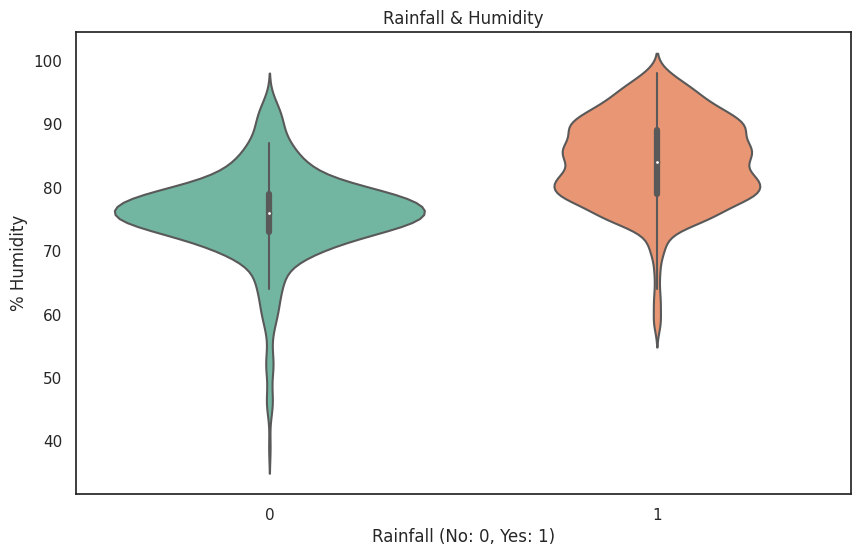

In [17]:
# Visualizing violin plot of 'rainfall' & 'humidity'
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_train, x='rainfall', y='humidity')
plt.title('Rainfall & Humidity')
plt.xlabel('Rainfall (No: 0, Yes: 1)')
plt.ylabel('% Humidity')
plt.show()

Above, we can see a violin plot of 'rainfall' and 'humidity'. Violin plots can help provide us with another view of the distribution of our target variable when paired with a feature. In the case of the plot above, we can see that class 0 of 'rainfall' clusters around an average humidity of about 75%, while class 1 clusters around an average humidity of about 85%. This may suggest that rainfall is occurring when the percentage humidity is greater.

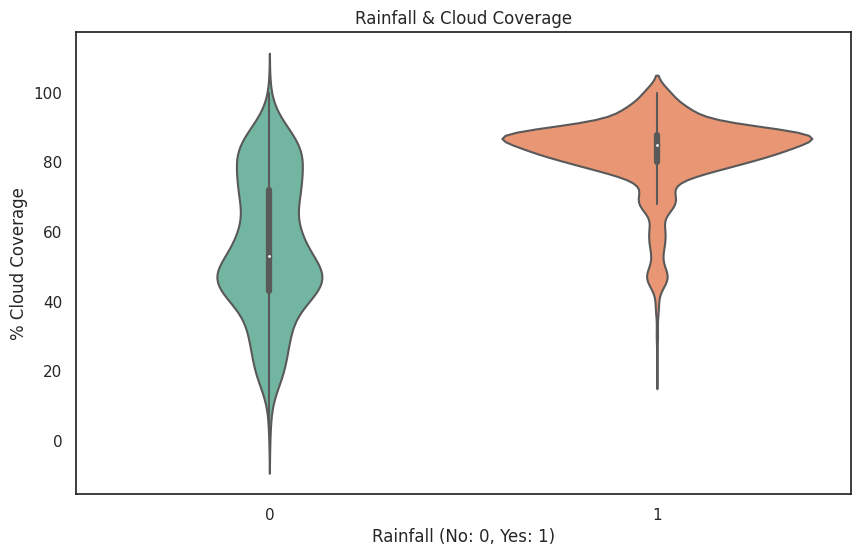

In [18]:
# Visualizing violin plot of 'rainfall' & 'cloud'
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_train, x='rainfall', y='cloud')
plt.title('Rainfall & Cloud Coverage')
plt.xlabel('Rainfall (No: 0, Yes: 1)')
plt.ylabel('% Cloud Coverage')
plt.show()

Above, we can see 'rainfall' and 'cloud'. The plot shows that class 0 clusters around a cloud coverage of roughly 55%, while class 1 clusters around roughly 85%. This may suggest that rain may be more likely to occur when there is a higher percentage of cloud coverage. 

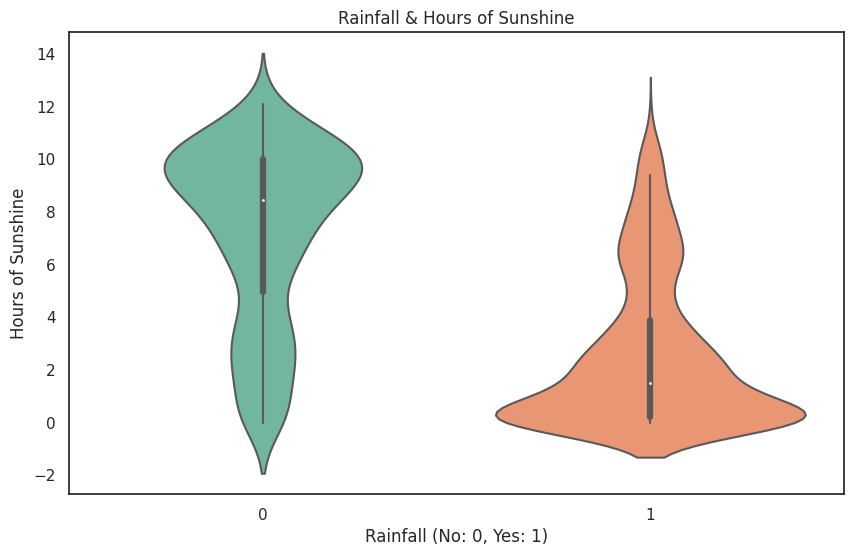

In [19]:
# Visualizing violin plot of 'rainfall' & 'sunshine'
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_train, x='rainfall', y='sunshine')
plt.title('Rainfall & Hours of Sunshine')
plt.xlabel('Rainfall (No: 0, Yes: 1)')
plt.ylabel('Hours of Sunshine')
plt.show()

Lastly, we can see 'rainfall' and 'sunshine'. Class 0 clusters around roughly 8 hours of sunshine, while class 1 clusters around roughly 1 hour. This suggests that rain occurs when there are fewer hours of sunshine.

<a id="toc"></a>

<a href="#toc" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#6" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="5"></a>
# **5) Adversarial Validation: Include Original Data?**

---

In this section, we want to determine whether or not the original data should be included (concatenated) with the train data provided by Kaggle. As stated by Kaggle, both the train and test sets were generated from a deep learned model trained on the original dataset. HOWEVER, Kaggle also states that the feature distributions are not exactly the same as the original. Thus, incorporating the original data into the training data may negatively impact model performance.

This section will leverage adversarial validation to determine the degree to which the distribution of the original data potentially varies from that of the train data. By combining the two datasets and labeling all train data as 0 and all original data as 1, a simple Catboost classifer will work to distinguish between the datasets. The cability of the classifier will be measured by the AUC on a ROC curve plot. If the AUC results are close to 0.5, essentially random guess, that means that the model is unable to determine the difference between the train and original datasets. In this case, we would have sufficient evidence that the two datasets come from the same distribution. However, if the AUC results are close to 1.0, essentially a perfect model, that means the model is easily able to detect a difference between the datasets and thus they are likely from different distributions.

In [20]:
# Viewing the first 5 entries of 'df_original'
df_original.head()

day  pressure   maxtemp  temparature  mintemp  dewpoint  humidity   cloud   \
0    1     1025.9     19.9         18.3     16.8      13.1         72      49   
1    2     1022.0     21.7         18.9     17.2      15.6         81      83   
2    3     1019.7     20.3         19.3     18.0      18.4         95      91   
3    4     1018.9     22.3         20.6     19.1      18.8         90      88   
4    5     1015.9     21.3         20.7     20.2      19.9         95      81   

  rainfall  sunshine           winddirection  windspeed  
0      yes       9.3                    80.0       26.3  
1      yes       0.6                    50.0       15.3  
2      yes       0.0                    40.0       14.2  
3      yes       1.0                    50.0       16.9  
4      yes       0.0                    40.0       13.7

In [21]:
# Looking at the info of 'df_original'
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day                     366 non-null    int64  
 1   pressure                366 non-null    float64
 2   maxtemp                 366 non-null    float64
 3   temparature             366 non-null    float64
 4   mintemp                 366 non-null    float64
 5   dewpoint                366 non-null    float64
 6   humidity                366 non-null    int64  
 7   cloud                   366 non-null    int64  
 8   rainfall                366 non-null    object 
 9   sunshine                366 non-null    float64
 10           winddirection  365 non-null    float64
 11  windspeed               365 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB


In [22]:
# Viewing column names of 'df_original'
df_original.columns

Index(['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection',
       'windspeed'],
      dtype='object')

Above, we can see that several of the column names in 'df_original' include unnecessary spaces. These column names will be fixed so that they correctly match the column names of the Kaggle datasets.

Furthermore, the 'rainfall' column is an object datatype (yes/no). This will be converted to numerical by mapping yes to 1 and no to 0. This will further ensure that the datatype of the 'rainfall' column will be identical in both the original and Kaggle datasets.

In [23]:
# Removing spaces in column names
df_original.columns = df_original.columns.str.strip()

In [24]:
# Converting 'rainfall' column in 'df_original' to int (yes=1, no=0)
df_original['rainfall'] = df_original['rainfall'].map({'yes': 1, 'no': 0})

In [25]:
# Verifying changes make to 'rainfall' column
df_original['rainfall']

0      1
1      1
2      1
3      1
4      1
      ..
361    1
362    1
363    1
364    1
365    0
Name: rainfall, Length: 366, dtype: int64

In [26]:
# Declaring feature columns
features = (['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
            'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed'])

In [27]:
# Creating new target column 'label', where all train set samples are labeled with 0, and all orignal set samples with 1
df_train['label'] = 0
df_original['label'] = 1
target = 'label'

# Combinging features and target label into 'all_cols'
all_cols = features + [target]

In [28]:
# Checking out the shape of 'all_cols' in train and original datasets
df_train[all_cols].shape, df_original[all_cols].shape

((2190, 12), (366, 12))

In [29]:
# Defining a function to create adversarial data: combines, shuffles, and re-splits the two datasets
# The resulting datasets include a mixture of the train and orignal data
def create_adversarial_data(df_train, df_original, cols, N_val=2000):
    df_master = pd.concat([df_train[cols], df_original[cols]], axis=0)
    adversarial_test = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[~df_master.index.isin(adversarial_test.index)]
    return adversarial_train, adversarial_test

# Applying function to train and orignal data, checking out the resulting shapes
adversarial_train, adversarial_test = create_adversarial_data(df_train, df_original, all_cols)
adversarial_train.shape, adversarial_test.shape

((424, 12), (2000, 12))

In [30]:
# Setting up the Catboost model for adversarial validation
train_data = Pool(
    data=adversarial_train[features],
    label=adversarial_train[target]
)
holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[target]
)

# Establishing parameters for the Catboost classifier
params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': 42,
    'verbose': 0
}

# Fitting the model to the data
model = CatBoostClassifier(**params)
_ = model.fit(train_data, eval_set=holdout_data)

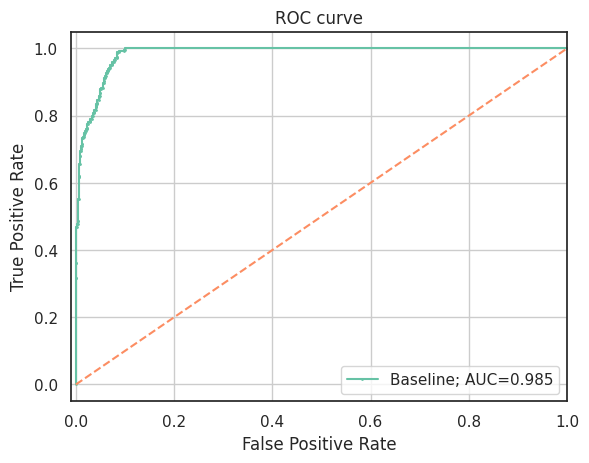

In [31]:
# Setting up ROC Curve plot
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')
    
# Plotting
plot_roc(
    [holdout_data.get_label()],
    [model.predict_proba(holdout_data)[:,1]],
    ['Baseline']
)

As we can see from the ROC curve plot above, the simple Catboost classifier was highly effective in differentiating between the original and synthetic datasets. In fact, the classifier yielded an AUC score of 0.984 (this value is subject to change slightly upon each run of the notebook), which is close to a perfect mode. Again, this signifies that the two datasets may not come from the same distribution. 

However, there are likely features that are significantly contributing to the difference between the distributions of these datasets. By plotting the feature importance (below), we can see if there are any such features.

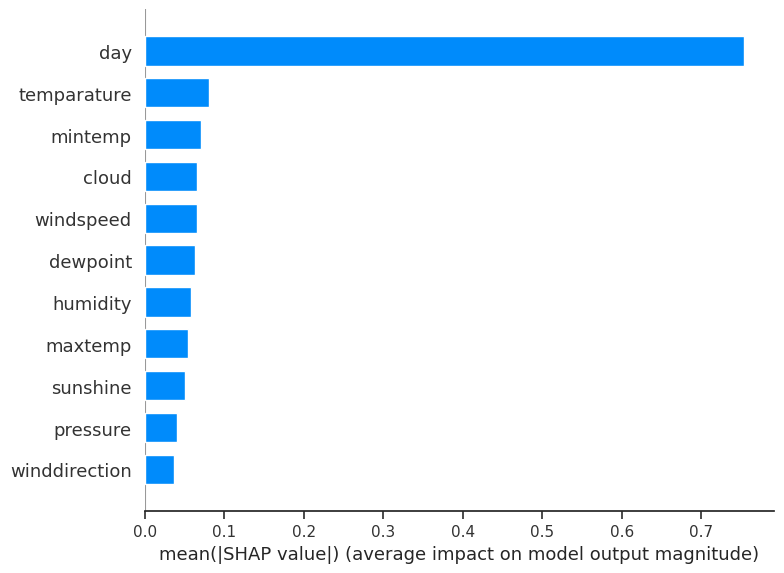

In [32]:
# Defining function to plot feature importance
def plot_importances(model, holdout_data, features):
    shap_values = model.get_feature_importance(holdout_data, type='ShapValues')
    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, holdout_data, feature_names=features, plot_type='bar')
    
# Plotting feature importance
plot_importances(model, holdout_data, features)

Above, we can see the feature importance plot from the Catboost classifier. Here, it is clear that 'day' holds the greatest feature importance. This may suggest that 'day' is contributing the most to the overall discrepancy between the distributions of the two datasets. We can remove this feature and re-run the model to see if the original and train datasets are truly from the same distribution or not. 

In [33]:
# Removing 'day' and retraining the model
params2 = dict(params)
params2.update({"ignored_features": ['day']})
model2 = CatBoostClassifier(**params2)
_ = model2.fit(train_data, eval_set=holdout_data, plot=False, verbose=False)

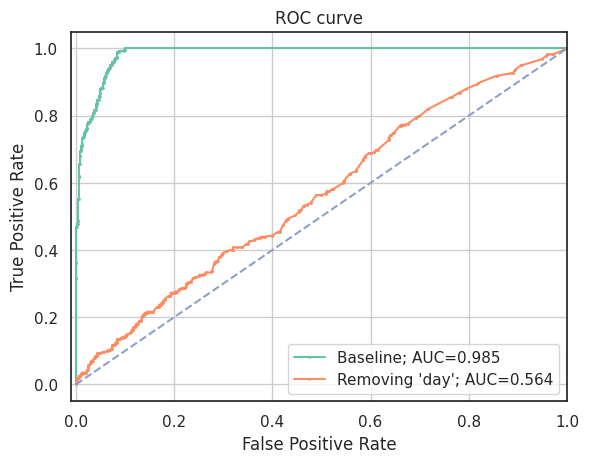

In [34]:
# Plotting updated ROC Curve plot
plot_roc(
    [holdout_data.get_label()]*2,
    [model.predict_proba(holdout_data)[:,1], model2.predict_proba(holdout_data)[:,1]],
    ['Baseline', "Removing 'day'"]
)

**Conclusion**

Adversarial validation enables us to determine whether or not two datasets (typically training and testing sets) are from the same distribution. In this case, we wanted to determine whether or not the training data provided by Kaggle follows the same distribution as the original data. The initial Catboost classifer yielded an AUC of around 0.98, initially indicating that the two datasets do not follow the same distribution.

However, after removing the most important feature, 'day', the resulting model yielded an AUC of around 0.57. This score is much closer to random guess (0.5) and suggests that the synthetic training data and the original data do in fact come from the same distribution. The main difference between these two datasets are the recorded days, which likely do not line up with each other. 

From these results, I have decided to include the original data for modeling, as its similar distribution to the synthetic data will likely not negatively impact future model performance. 

<a id="toc"></a>

<a href="#toc" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#7" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="6"></a>
# **6) Data Preprocessing**

---

<a id="toc"></a>
<a id="6.1"></a>
## **6.1) Combining the Data**

In [35]:
# Re-loading in training and testing sets
df_train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv", index_col=0)
df_test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
# Re-loading in the original data
df_original = pd.read_csv("/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv")

In [36]:
# Extracting ids from 'df_test' for later submission
ids = df_test['id']

In [37]:
# Dropping 'id' column from 'df_test'
df_test.drop(['id'], axis=1, inplace=True)

In [38]:
# Reapplying cleaning steps to 'df_original'
df_original.columns = df_original.columns.str.strip()
df_original['rainfall'] = df_original['rainfall'].map({'yes': 1, 'no': 0})

In [39]:
# Combining the 'df_train' and 'df_original' datasets
df_combined = pd.concat([df_train, df_original], axis=0, ignore_index=True)

<a id="toc"></a>
<a id="6.2"></a>
## **6.2) Missing Values**

In [40]:
# Checking for nulls in 'df_combined'
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2556 non-null   int64  
 1   pressure       2556 non-null   float64
 2   maxtemp        2556 non-null   float64
 3   temparature    2556 non-null   float64
 4   mintemp        2556 non-null   float64
 5   dewpoint       2556 non-null   float64
 6   humidity       2556 non-null   float64
 7   cloud          2556 non-null   float64
 8   sunshine       2556 non-null   float64
 9   winddirection  2555 non-null   float64
 10  windspeed      2555 non-null   float64
 11  rainfall       2556 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 239.8 KB


In [41]:
# Filling in null values with the column mean for 'winddirection' and 'windspeed'
df_combined['winddirection'].fillna(df_combined['winddirection'].mean(), inplace=True)
df_combined['windspeed'].fillna(df_combined['windspeed'].mean(), inplace=True)

In [42]:
# Checking for nulls in 'df_test'
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            730 non-null    int64  
 1   pressure       730 non-null    float64
 2   maxtemp        730 non-null    float64
 3   temparature    730 non-null    float64
 4   mintemp        730 non-null    float64
 5   dewpoint       730 non-null    float64
 6   humidity       730 non-null    float64
 7   cloud          730 non-null    float64
 8   sunshine       730 non-null    float64
 9   winddirection  729 non-null    float64
 10  windspeed      730 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 62.9 KB


In [43]:
# Filling in null values with the column mean for 'winddirection'
df_test['winddirection'].fillna(df_test['winddirection'].mean(), inplace=True)

**Conclusion: Missing Values**
- Combined data: Replaced missing values (2) in 'winddirection' and 'windspeed' columns with column means
- Test data: Replaced missing value (1) in 'winddirection' with column mean

<a id="toc"></a>
<a id="6.3"></a>
## **6.3) Removing Outliers**

In [44]:
# Declaring which columns should be checked for outliers
cols = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']

# Creating function to remove outliers by applying the Inter Quartile method
def remove_outliers(data, column):
    # Calculating the Inter Quartile Range (IQR) 
    Q1 = data[column].quantile(0.15)
    Q3 = data[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtering the data, including all data between the lower and upper bounds
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    # Calculating the number of rows deleted
    rows_deleted = len(data) - len(filtered_data)
    return filtered_data, rows_deleted

# Applying the 'remove_outliers' function to each column in 'train' dataset
rows_deleted_total = 0

for column in cols:
    df_combined, rows_deleted = remove_outliers(df_combined, column)
    rows_deleted_total += rows_deleted
    print(f"{column}: {rows_deleted}")

print(f"Total rows deleted: {rows_deleted_total}")

pressure: 0
maxtemp: 0
temparature: 0
mintemp: 0
dewpoint: 0
humidity: 18
cloud: 0
sunshine: 0
winddirection: 0
windspeed: 0
Total rows deleted: 18


**Conclusion: Removing Outliers**
- Removed all outliers outside of the IQR
- Total rows deleted: 18

<a id="toc"></a>
<a id="6.4"></a>
## **6.4) Feature Engineering**

In [45]:
# This code chunk has been adapted from a great work by Sanad Alali (Kudos!)

# Creating a function to create new features 
def create_features(df):

    # Creating a copy of the original dataframe
    df_new = df.copy()
    
    # Creating temperature-based features
    df_new['temp_range'] = df_new['maxtemp'] - df_new['mintemp']
    df_new['temp_ratio'] = df_new['temparature'] / df_new['maxtemp']
    df_new['temp_from_dewpoint'] = df_new['temparature'] - df_new['dewpoint']
    df_new['max_min_temp_ratio'] = df_new['maxtemp'] / df_new['mintemp']
    
    # Creating humidity-based features
    df_new['humid_temp_interaction'] = df_new['humidity'] * df_new['temparature']
    df_new['humid_pressure_interaction'] = df_new['humidity'] * df_new['pressure']
    df_new['humid_dewpoint_interaction'] = df_new['humidity'] * df_new['dewpoint']
    
    # Creating cloud-based features
    df_new['cloud_sunshine_ratio'] = df_new['cloud'] / (df_new['sunshine'] + 1)  # Adding 1 to avoid division by zero
    df_new['cloud_coverage_rate'] = df_new['cloud'] / 100  # Normalize to 0-1 range
    
    # Creating pressure-based features
    df_new['pressure_temp_ratio'] = df_new['pressure'] / df_new['temparature']
    df_new['pressure_humidity_ratio'] = df_new['pressure'] / df_new['humidity']
    
    # Creating combined weather features
    df_new['weather_severity'] = (df_new['cloud'] * df_new['humidity']) / (df_new['pressure'] * (df_new['sunshine'] + 1))
    df_new['temp_humidity_index'] = (df_new['temparature'] * df_new['humidity']) / 100
    df_new['pressure_temp_humidity'] = (df_new['pressure'] * df_new['temparature']) / df_new['humidity']
    
    return df_new

# Applying 'create_features' function to train and test datasets
df_combined = create_features(df_combined)
df_test = create_features(df_test)

<a id="toc"></a>
<a id="6.5"></a>
## **6.5) Feature Scaling**

In [46]:
# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Fitting the 'df_combined' data to the scaler
train_scaled = scaler.fit_transform(df_combined)
# Scaling the data
train = pd.DataFrame(train_scaled, columns=df_combined.columns)

In [47]:
# Viewing scaling changes to 'train'
train.head()

day  pressure   maxtemp  temparature   mintemp  dewpoint  humidity  \
0  0.000000  0.523546  0.482877     0.570909  0.624535  0.724528  0.750000   
1  0.002747  0.581717  0.311644     0.436364  0.472119  0.573585  0.931818   
2  0.005495  0.709141  0.421233     0.407273  0.427509  0.343396  0.477273   
3  0.008242  0.412742  0.376712     0.469091  0.513011  0.626415  0.931818   
4  0.013736  0.670360  0.462329     0.498182  0.498141  0.464151  0.568182   

      cloud  sunshine  winddirection  ...  humid_temp_interaction  \
0  0.877551  0.090909       0.147059  ...                0.591757   
1  0.908163  0.000000       0.117647  ...                0.517773   
2  0.459184  0.685950       0.176471  ...                0.360055   
3  0.948980  0.000000       0.147059  ...                0.551654   
4  0.806122  0.000000       0.029412  ...                0.463840   

   humid_pressure_interaction  humid_dewpoint_interaction  \
0                    0.740023                    0.667225   
1                    0.924831                    0.577549   
2                    0.480581                    0.272180   
3                    0.911988                    0.630605   
4                    0.568917                    0.387865   

   cloud_sunshine_ratio  cloud_coverage_rate  pressure_temp_ratio  \
0              0.418008             0.877551             0.102983   
1              0.909839             0.908163             0.163635   
2              0.048839             0.459184             0.181843   
3              0.949911             0.948980             0.144820   
4              0.809660             0.806122             0.134013   

   pressure_humidity_ratio  weather_severity  temp_humidity_index  \
0                 0.164466          0.369334             0.591757   
1                 0.054060          0.875912             0.517773   
2                 0.389299          0.036885             0.360055   
3                 0.046696          0.919988             0.551654   
4                 0.307975          0.645949             0.463840   

   pressure_temp_humidity  
0                0.350483  
1                0.218241  
2                0.303703  
3                0.237155  
4                0.350230  

[5 rows x 26 columns]

In [48]:
# Applying scaling steps to 'df_test'
test_scaled = scaler.fit_transform(df_test)
test = pd.DataFrame(test_scaled, columns=df_test.columns)

In [49]:
# Viewing scaling changes to 'test'
test.head()

day  pressure   maxtemp  temparature   mintemp  dewpoint  humidity  \
0  0.000000  0.605590  0.355634     0.382239  0.341365  0.558052  0.966102   
1  0.002747  0.512422  0.355634     0.409266  0.465863  0.565543  0.983051   
2  0.005495  0.742236  0.133803     0.173745  0.208835  0.333333  0.796610   
3  0.008242  0.711180  0.464789     0.440154  0.441767  0.355805  0.610169   
4  0.010989  0.689441  0.306338     0.305019  0.088353  0.161049  0.491525   

   cloud  sunshine  winddirection  ...  humid_temp_interaction  \
0   0.99  0.000000       0.137931  ...                0.476416   
1   0.99  0.000000       0.137931  ...                0.512736   
2   0.96  0.000000       0.103448  ...                0.206335   
3   0.45  0.601695       0.034483  ...                0.381254   
4   0.49  0.779661       0.034483  ...                0.225429   

   humid_pressure_interaction  humid_dewpoint_interaction  \
0                    0.965448                    0.587530   
1                    0.977560                    0.601618   
2                    0.802237                    0.314384   
3                    0.613733                    0.292656   
4                    0.493895                    0.120102   

   cloud_sunshine_ratio  cloud_coverage_rate  pressure_temp_ratio  \
0              0.990000                 0.99             0.232064   
1              0.990000                 0.99             0.211484   
2              0.960000                 0.96             0.471235   
3              0.055556                 0.45             0.194009   
4              0.048039                 0.49             0.299368   

   pressure_humidity_ratio  weather_severity  temp_humidity_index  \
0                 0.019206          0.970176             0.476416   
1                 0.010349          0.983176             0.512736   
2                 0.100323          0.839158             0.206335   
3                 0.209624          0.042392             0.381254   
4                 0.297532          0.033258             0.225429   

   pressure_temp_humidity  
0                0.200752  
1                0.213166  
2                0.094074  
3                0.366099  
4                0.296952  

[5 rows x 25 columns]

<a id="toc"></a>

<a href="#toc" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#8" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="7"></a>
# **7) Building the Model**

---

As mentioned in the 'About the Project' section, we will be building an XGBoost (XGB) model. Again, XGB is an optimized distributed gradient boosting algorithm that leverages parallel tree boosting to solve a majority of data science tasks. In other words, this technique builds an ensemble of decision trees sequentially so that each tree can correct any errors made by the previous one. XBGs are extremely effective in handling classification and regression tasks. Moreover, XGB utilizes regularization techniques, which help prevent overfitting and thus improve the model's ability to generalize its results on novel data. 

This section will first build and fit a baseline XGB model to the data. This basic model will have all its parameters set to its default values, excluding the 'objective' (set to 'binary:logistic') and the 'eval_metric' (set to 'auc'). The 'objective' parameter refers to the corresponding learning objective of the model. In the case of this project, we are aiming to solve a binary classification task, where the outcomes of rainfall are probabalistic. The 'eval_metric' parameter refers to the evaluation metrics used for the validation data. This Kaggle competition is scored based upon the AUC-ROC score and thus I have set this parameter to 'auc'.

After evaluating the baseline model, I will leverage Optuna (a hyperparameter optimization framework) to identify the optimal parameter values for the XGB model. This final model will be evaluated and compared to the baseline model. 

<a id="toc"></a>
<a id="7.1"></a>
## **7.1) Baseline Model**

In [50]:
# Splitting 'train' dataset into features (X) and target (y)
X = train.drop(['rainfall'], axis=1)
y = train['rainfall']
# Splitting data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [51]:
# Fitting the baseline model to the training data
baseline_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)
baseline_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [52]:
# Evaluating the baseline model's performance (auc score) on the validation data
y_val_pred_proba = baseline_model.predict_proba(X_valid)[:, 1]
auc_score = roc_auc_score(y_valid, y_val_pred_proba)
print(f'Baseline Model ROC-AUC Score: {auc_score:.4f}')

Baseline Model ROC-AUC Score: 0.8412


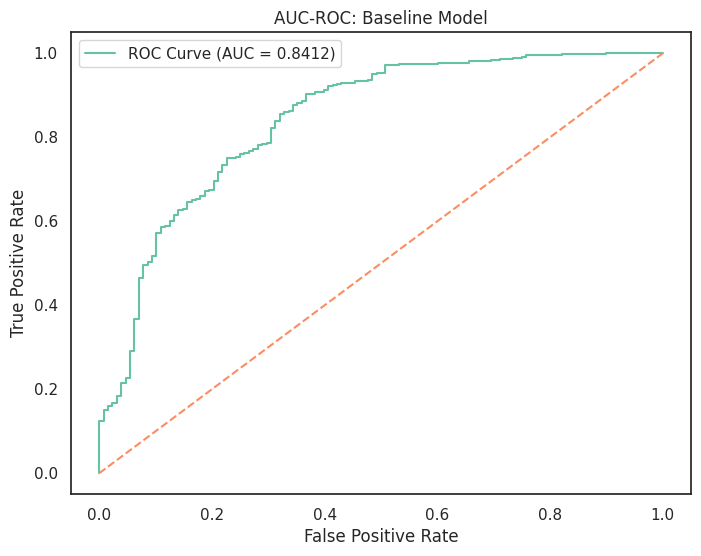

In [53]:
# Plotting the AUC-ROC curve of the baseline model
fpr, tpr, thresholds = roc_curve(y_valid, y_val_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC: Baseline Model")
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

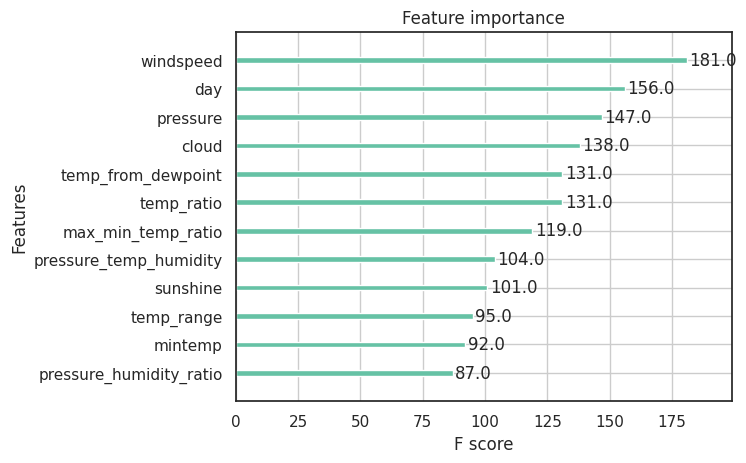

In [54]:
# Plotting feature importance of the baseline model
xgb.plot_importance(baseline_model, max_num_features=12)

<a id="toc"></a>
<a id="7.2"></a>
## **7.2) Optimizing with Optuna**

**Predetermined Parameters**
- 'objective': 'binary:logistic' --> as explained above, the objective parameter is set to binary:logistic, as this is a binary classification problem
- 'device': 'cpu' --> we are relying solely on the cpu for this project, as it supports all XGB functionality
- 'eval_metric': 'auc' --> as explained above, the submission of this project is evaluated using the AUC-ROC score
- 'random_state': 42 --> this sets a random state which can be used for reproducing specific results
- 'verbosity': 1 --> this lowers the verbosity (amount of text generated) of the model

**Parameters Needing Optimization**
- 'n_estimators' --> essentially the number of boosting iterations
- 'learning_rate' --> also called eta, the shrinkage rate, helps prevent overfitting, a smaller learning rate may improve performance but may also slow training, default=0.3, range: [0,1] 
- 'colsample_bytree' --> the subsample ratio of columns when constructing each tree, helps speed up training and may improve performance, default=1, range: (0,1]
- 'max_depth' --> this limits the max depth of the tree model, deeper trees can capture more complex patterns but may also overfit, a deeper tree may aggressively consume more memory, default=6, range: [0,inf]
- 'subsample' --> similar to "colsample_bytree" but randomly selects part of the data without resampling, can also be used to speed up training and prevent overfitting, setting to 0.5 would make the model randomly sample half of the training data prior to growing trees, defaul=1, range:(0,1]
- 'min_child_weight' --> minimum sum of instance weight needed in a child, a larger weight will create a more conversative model, default=1, range: [0,inf]
- 'reg_alpha' --> also called alpha, L1 regularization term on weights, increasing this will make the model more conservation, default=0, range: [0,inf]
- 'reg_lambda' --> also called lambda, L2 regularization term on weights, increasing this will make the model more conservation, default=0, range: [0,inf]

In [55]:
# Creating 'objective' function which will trial different parameter values and combinations
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'device': 'cpu',
        'eval_metric': 'auc',
        'random_state': 42,
        'verbosity': 1,
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True) 
    }

    # Fitting XGBoost model with parameters from the trials
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Making predictions on the validation set
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_pred_proba)
    print('ROC-AUC:', score)
    return score

# When set to 1, optuna will create a study to find the optimal parameters for the model
run=0

if run==1:

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    print('Best trial:')
    trial = study.best_trial

    print('Value: {}'.format(trial.value))
    print('Params: ')
    for key, value in trial.params.items():
        print(' {}: {}'.format(key, value))

In [56]:
# Recording best parameters from trial #1
best_params = {
    'objective': 'binary:logistic',
    'device': 'cpu',
    'eval_metric': 'auc',
    'random_state': 42,
    'n_estimators': 727,
    'learning_rate': 0.02065809145104903,
    'colsample_bytree': 0.6844525799009806,
    'max_depth': 1,
    'subsample': 0.519006802168094,
    'min_child_weight': 5,
    'reg_alpha': 0.00015480424761672249,
    'reg_lambda': 0.2256543295563229
    }

In [57]:
# Recording best parameters from trial #2
best_params_2 = {
    'objective': 'binary:logistic',
    'device': 'cpu',
    'eval_metric': 'auc',
    'random_state': 42,
    'n_estimators': 528,
    'learning_rate': 0.010070446663886614,
    'colsample_bytree': 0.3755118358739974,
    'max_depth': 9,
    'subsample': 0.43796953742273803,
    'min_child_weight': 6,
    'reg_alpha': 2.01368738947277e-08,
    'reg_lambda': 9.989919055463442e-08
    }

In [58]:
# Fitting the model with the best parameters!
final_model = xgb.XGBClassifier(**best_params)

<a id="toc"></a>

<a href="#toc" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#9" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="8"></a>
# **8) Model Evaluation**

---

In [59]:
# Training the model
final_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=40, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6844525799009806, device='cpu',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02065809145104903,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=727, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [60]:
# Making predictions on the validation set
y_val_pred_proba = final_model.predict_proba(X_valid)[:, 1]  
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)  

In [61]:
# Evaluating the performance of the final model
auc_score = roc_auc_score(y_valid, y_val_pred_proba)
print(f'Validation ROC-AUC Score: {auc_score:.4f}')

Validation ROC-AUC Score: 0.8712


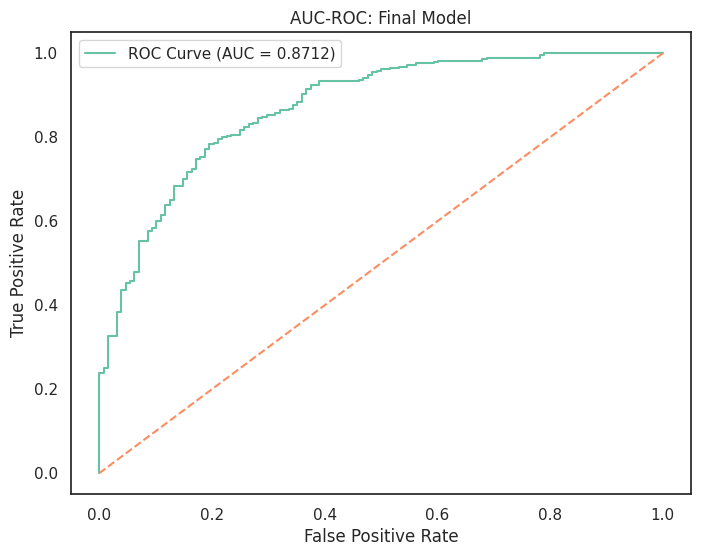

In [62]:
# Plotting the AUC-ROC curve of the final model
fpr, tpr, thresholds = roc_curve(y_valid, y_val_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC: Final Model")
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

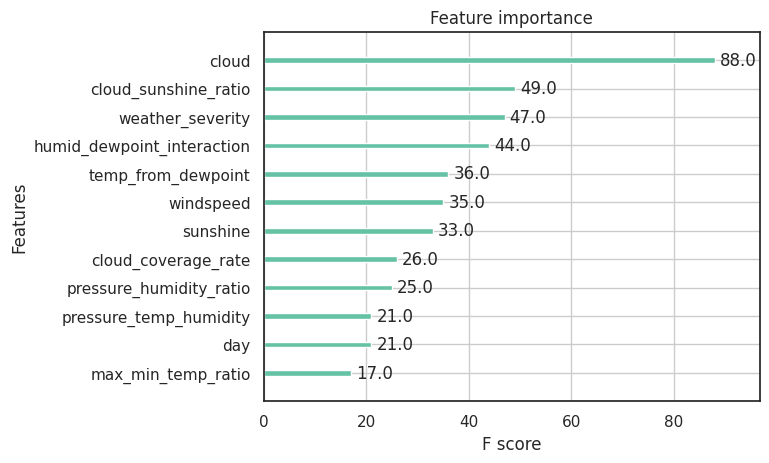

In [63]:
# Plotting feature importance of the final model
xgb.plot_importance(final_model, max_num_features=12)

<a id="toc"></a>

<a href="#toc" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#10" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="9"></a>
# **9) Conclusion**

---

**Model Performance**

The final model (tuned with Optuna) yielded an AUC-ROC score of 0.8712 on the validation data. This results in a slight improvement over the baseline model which yielded a score of 0.8412. Overall, this represents a roughly 3.56% increase in model performance. 

In terms of feature importance in the final model, 'cloud' yielded the highest F score of 88. This differs greatly from the feature importance of the baseline model, where 'windspeed' yielded the highesst F score of 181. 

Generally speaking, an AUC-ROC score of ~0.87 is solid. In truth, there is no specific threshold for what is considered a good AUC-ROC score. Obviously a model scoring closer to 1.0 will tend to better classify novel data into the correct classes. In [*Applied Logistic Regression*](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118548387) (Hosmer, Lemeshow, & Sturdivant, 2013), the following guideline is provided:
- 0.5: No discrimination
- 0.5-0.7: Poor discrimination
- 0.7-0.8: Acceptable discrimination
- 0.8-0.9: Excellent discrimination
- Greater than 0.9: Outstanding discrimination

Based upon this general guideline, the final XGB model would be considered to have excellent discrimination. However, if the performance of this model were to be generalized to other problems, such as identifying cancer cells in tissue samples, I would prefer to have a much higher AUC score. In cases such as that, the cost of misidentifying classes is much greater than misidentifying whether or not it will rain. 

**Considerations**

If this notebook were to be applied in a professional setting, I wonder if the 3.56% increase in performance via Optuna optimization would be worth the additional time and computational complexity. In other words, in any given situation, would it be more or less beneficial to utilize the baseline model over the tuned, final model?

What methods of this project could be changed to elicit a better AUC score?
- Not including the original dataset in the training pool
- Adjusting IQR to remove more/less outliers
- Keeping any outliers in the training data
- Creating more features from interactions
- Forgoing the creation of novel features from interactions
- Using different scaling techniques
- Forgoing the use of scaling

**Discussion: XGBoost vs. Deep Learning**

In the article [*Building Reliable Machine Learning Models: Lessons from Brian Lucena*](https://opendatascience.com/building-reliable-machine-learning-models-lessons-from-brian-lucena/), Brian Lucena (PhD, Principal at Numeristical) discusses how gradient boosting techniques remain a 'gold standard' in solving tabular data problems. As mentioned earlier in this project, XGBoost is a gradient boosting technique that builds an ensemble of decision trees sequentially so that each tree can correct any errors made by the previous one. XGBoost and other gradient boosting techniques (such as LightGBM and CatBoost) are excellent for regression and classification tasks and are often seen used in Kaggle competitions. In this article, Lucena argues that gradient boosting may still outperform deep learning for many business applications. This is due to the fact that gradient boosting:
- **handles tabular data more effectively**
- **works well with smaller datasets**
- **is more interpretable**

Firstly, neural networks can often struggle with structured data, while gradient boosting methods can 'make sharp splits in variables, capturing discontinous changes'. Secondly, deep learning requires incredibly large amounts of data. In contrast, gradient boosting can yield solid performance with relatively smaller datasets (like the Kaggle data used in this project). Lastly, deep learning is often considered to be a black box, i.e. we may know its inputs and outputs but not necessarily its inner workings. The decision trees in gradient boosting can instead help provide us a clearer picture of *why* the model is making a particular prediction.

<a id="toc"></a>

<a href="#toc" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#r" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="10"></a>
# **10) Submission**

---

In [64]:
# Making predictions on the test data
preds = final_model.predict_proba(test)[:,1]

In [65]:
# Creating 'submission' dataframe to store predictions with ids
submission = pd.DataFrame({'id': ids, 'rainfall': preds})
submission

id  rainfall
0    2190  0.973394
1    2191  0.974607
2    2192  0.948613
3    2193  0.233703
4    2194  0.099446
..    ...       ...
725  2915  0.970424
726  2916  0.904520
727  2917  0.969244
728  2918  0.976623
729  2919  0.932315

[730 rows x 2 columns]

In [66]:
# Creating .csv file for submissions and scoring
run = 1

if run == 1:
    submission.to_csv('submission.csv', index=False)

<a id="toc"></a>

<a href="#toc" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a id="r"></a>
# **References**

- Kaggle Competition: https://www.kaggle.com/competitions/playground-series-s5e3/overview
- XGBoost: https://xgboost.readthedocs.io/en/latest/index.html
- Optuna: https://optuna.org/
- ROC Curve: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
- Original Dataset: https://www.kaggle.com/datasets/subho117/rainfall-prediction-using-machine-learning
- Kudos: https://www.kaggle.com/code/sanadalali/xgboost-rainfall-roc-auc-0-86511/notebook#Hyperparameter-tuning-using-Optuna
- *Applied Logistic Regression*: https://onlinelibrary.wiley.com/doi/book/10.1002/9781118548387
- *Building Reliable Machine Learning Models: Lessons from Brian Lucena*: https://opendatascience.com/building-reliable-machine-learning-models-lessons-from-brian-lucena/